In [1]:
import backtrader as bt

class SmaCrossStrategy(bt.Strategy):
    params = dict(
        sma_short_period=10,
        sma_long_period=50,
    )

    def __init__(self):
        self.sma_short = bt.ind.SMA(period=self.p.sma_short_period)
        self.sma_long = bt.ind.SMA(period=self.p.sma_long_period)
        self.crossover = bt.ind.CrossOver(self.sma_short, self.sma_long)

    def next(self):
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.sell()

In [47]:
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start='2024-06-01', end='2025-02-13')
# Flatten the MultiIndex columns by taking their first level
data.columns = [col[0] for col in data.columns]
# Select columns required by Backtrader and convert them to lowercase
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = [col.lower() for col in data.columns]
data_bt = bt.feeds.PandasData(dataname=data)

[*********************100%***********************]  1 of 1 completed

In [55]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCrossStrategy)
cerebro.adddata(data_bt)
cerebro.broker.set_cash(100000.0)
cerebro.broker.setcommission(commission=0.001)  # handling fee to 0.1%
cerebro.broker.set_slippage_perc(0.001)      # slippage to 0.1%  
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown') 
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.run()


In [ ]:
# Print out the final result
results = cerebro.run()
sharpe = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()

print(f"Final net asset value: {cerebro.broker.getvalue():.2f}")
print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")
print(f"Maximum drawdown: {drawdown.max.drawdown:.2f}%")
print(f"Total trade times: {trade_analyzer.total.closed}")

Final net asset value: 100108.02
Sharpe Ratio: -13.30
Maximum drawdown: 0.10%
Total trade times: 2


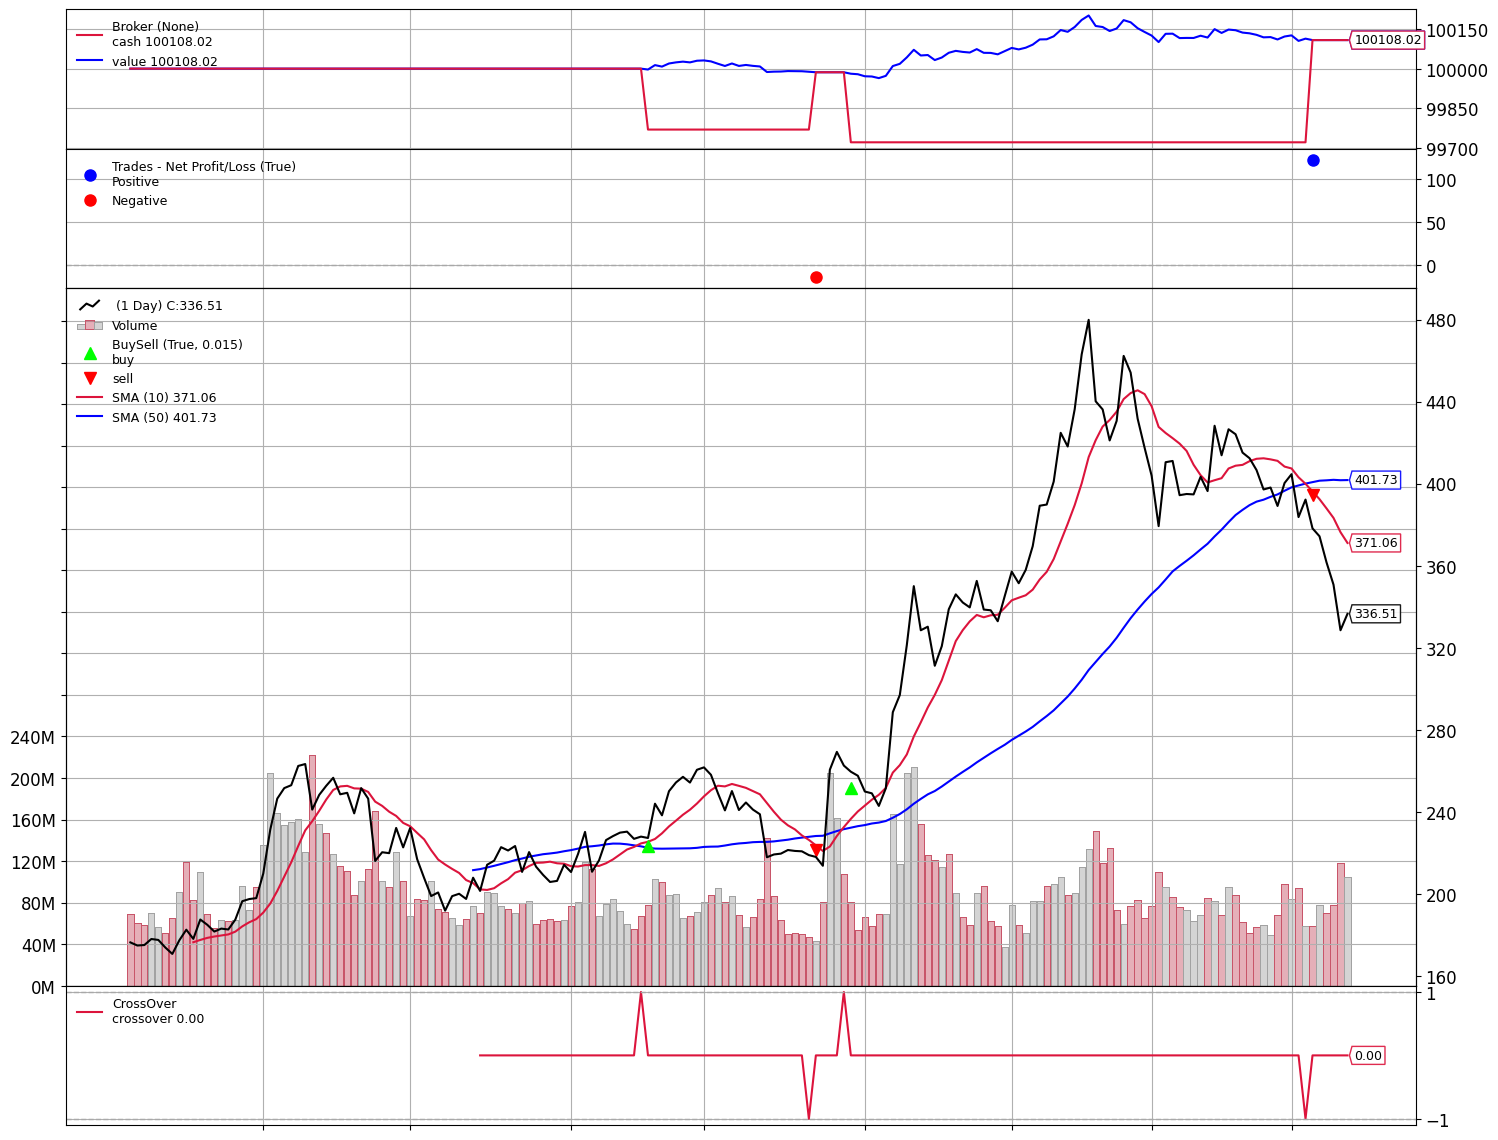

[[<Figure size 1500x1200 with 5 Axes>]]

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
cerebro.plot(iplot = False)